In [ ]:
!pip install supervision ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.1/660.1 kB 7.7 MB/s eta 0:00:00


In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv

In [ ]:
model = YOLO("yolov8n.pt")
image = cv2.imread("/content/Screenshot 2023-12-09 104602.png")
results = model(image)[0]
detections = sv.Detections.from_ultralytics(results)

100%|██████████| 6.23M/6.23M [00:00<00:00, 55.0MB/s]



0: 544x640 3 persons, 10 cars, 1 motorcycle, 2 buss, 1 truck, 197.1ms
Speed: 21.2ms preprocess, 197.1ms inference, 38.0ms postprocess per image at shape (1, 3, 544, 640)


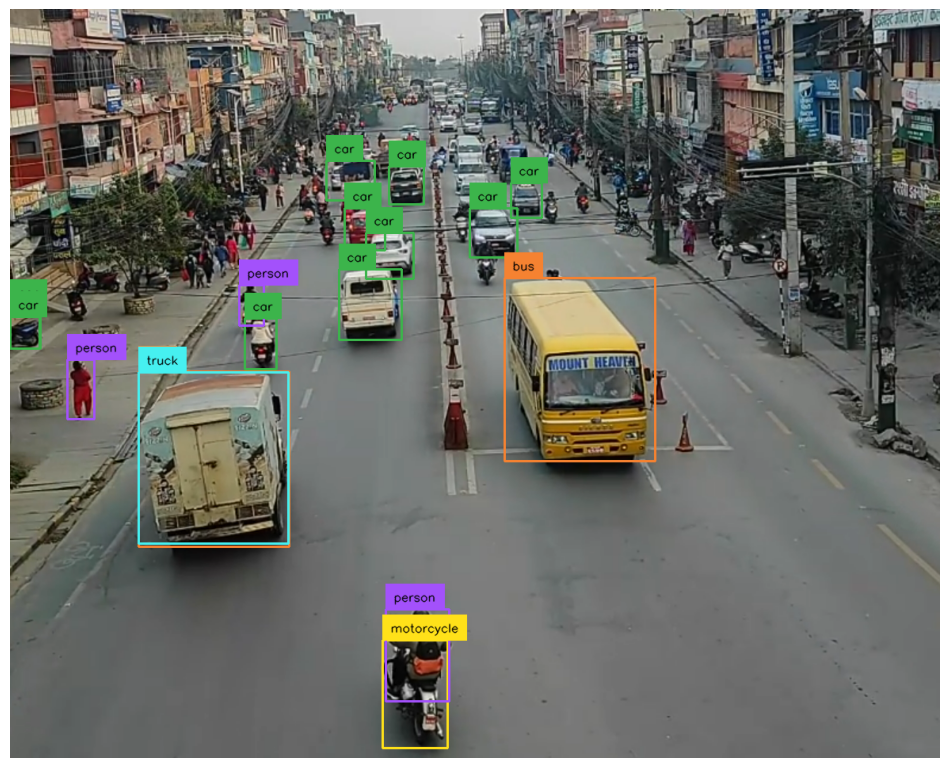

In [ ]:
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

labels = [
    results.names[class_id]
    for class_id
    in detections.class_id
]

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)

annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels)
sv.plot_image(annotated_image)



In [ ]:
import numpy as np
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
VIDEO = "/content/drive/MyDrive/trained_model/prithvi-side.mp4"

colors = sv.ColorPalette.default()
video_info = sv.VideoInfo.from_video_path(VIDEO)
video_info

VideoInfo(width=1280, height=720, fps=25, total_frames=1523)

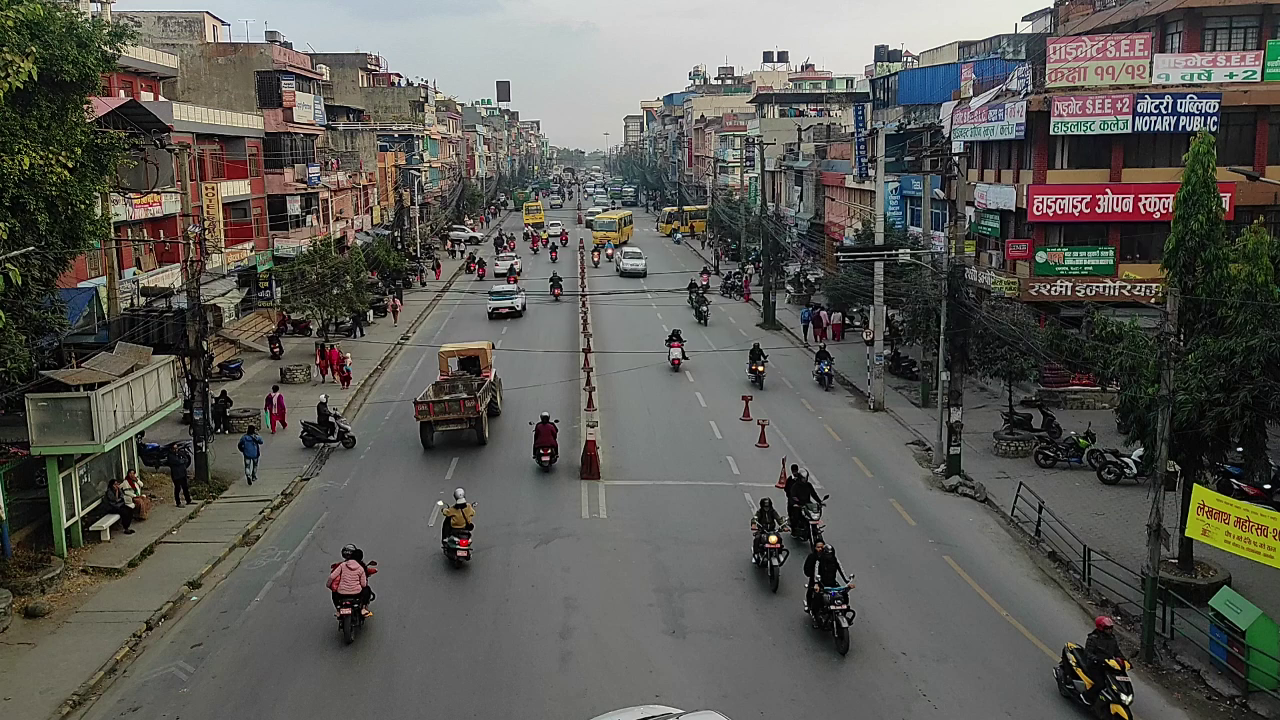

In [ ]:
from google.colab.patches import cv2_imshow  # Required to display images in Colab

# extract one image from the video (frame)
generator = sv.get_video_frames_generator(VIDEO)
iterator = iter(generator) #loop over the frames

frame = next(iterator) #get the first frame

# save first frame
cv2.imwrite("first_frame.png", frame)
image = cv2.imread(f"{HOME}/first_frame.png")
#print(image)
cv2_imshow(image)


In [ ]:
polygons =[
np.array([
[610, 646],[582, 242],[694, 238],[1110, 626],[602, 646]
])
]

In [ ]:
zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]

In [ ]:
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]

In [ ]:
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4,
        text_scale=2
        )
    for index
    in range(len(polygons))
]

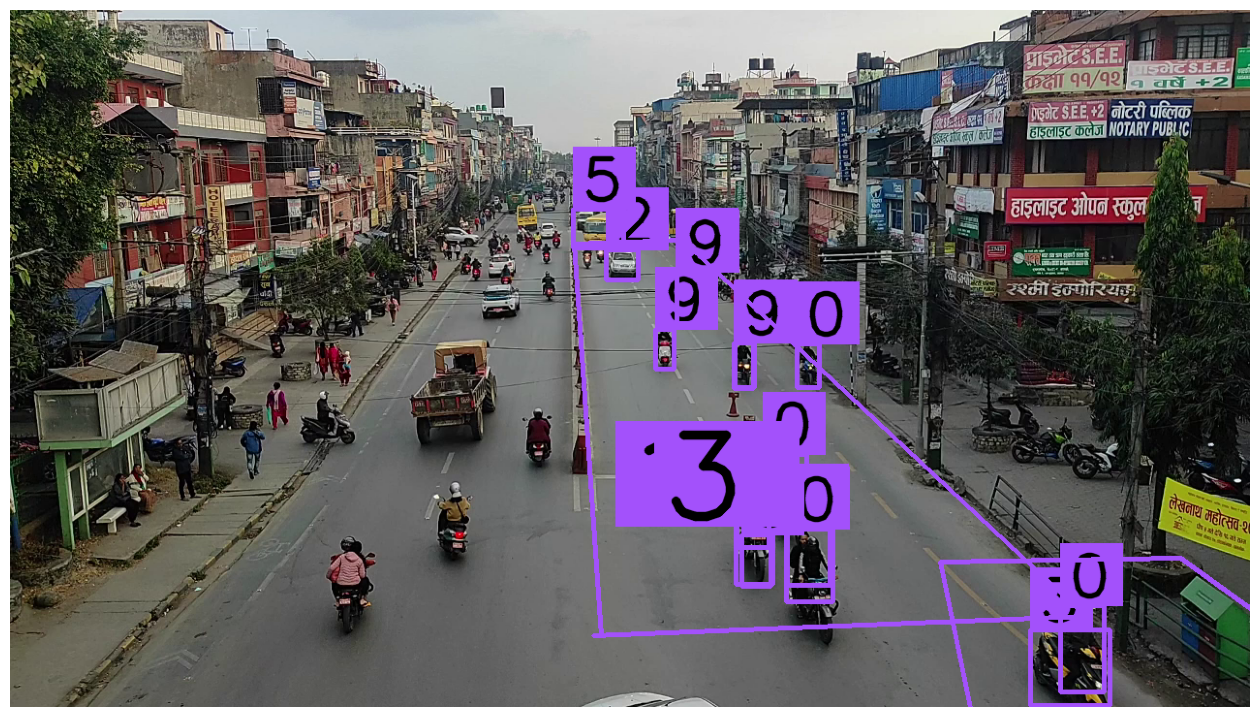

In [ ]:
results = model(frame, imgsz=640, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
    frame = zone_annotator.annotate(scene=frame)

sv.plot_image(frame, (16, 16))

In [ ]:
def process_frame(frame: np.ndarray, i) -> np.ndarray:
    results = model(frame, imgsz=1280, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
        frame = zone_annotator.annotate(scene=frame)

    return frame

In [ ]:
sv.process_video(source_path=VIDEO, target_path="result.mp4", callback=process_frame)


In [ ]:
g